# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [1]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.35MB/s]


In [2]:
train[0][0].shape

torch.Size([1, 28, 28])

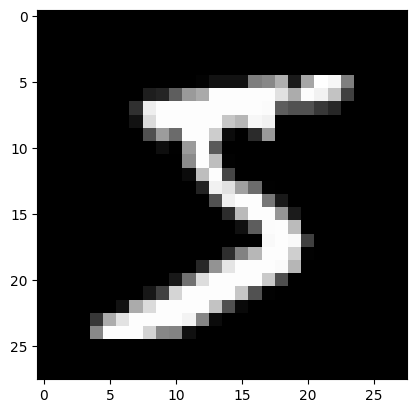

In [3]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

In [33]:
from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=45),
    v2.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    v2.ToTensor()  # Am Ende: immer in Tensor umwandeln!

])




/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [34]:
from torchvision import datasets
train_dataset = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transform
)


In [50]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=64,       # oder eine andere Batchgröße
    shuffle=True,        # mischt die Daten zu jedem Epochstart
    num_workers=2        # für paralleles Laden (je nach System)
)


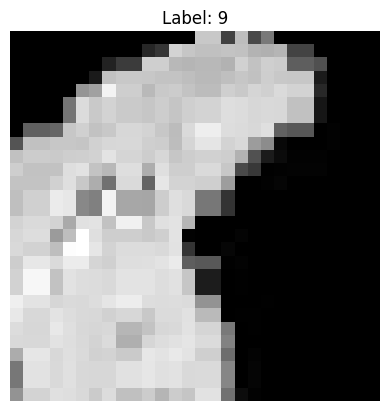

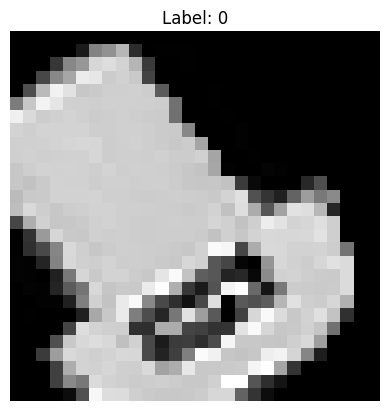

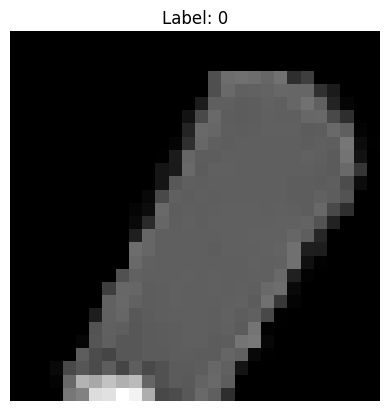

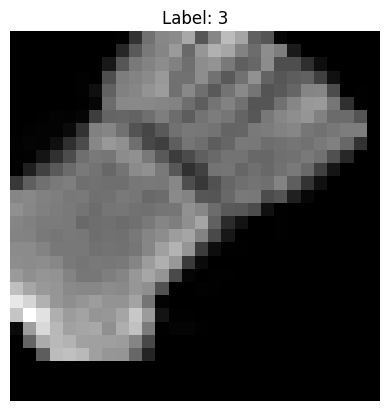

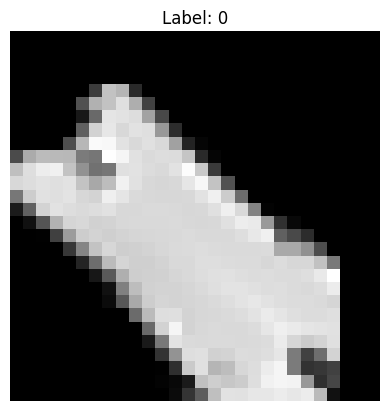

In [35]:
import matplotlib.pyplot as plt

for i in range(5):
    img, label = train_dataset[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [42]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.4):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [43]:
from torchvision import transforms
# Basis-Transformation: ToTensor (damit wir mit Tensoren rechnen)
transform = transforms.ToTensor()

# Dataset laden ohne Noise (für Zielbilder)
dataset_clean = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Dataset laden mit Noise (für Eingabebilder)
transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.3)
])
dataset_noisy = datasets.FashionMNIST(root='./data', train=True, transform=transform_noisy, download=True)

loader_noisy = DataLoader(dataset_noisy, batch_size=64, shuffle=True)
loader_clean = DataLoader(dataset_clean, batch_size=64, shuffle=True)

In [44]:
import torch.nn as nn
import torch

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Werte zwischen 0 und 1 für Bilder
            nn.Unflatten(1, (1, 28, 28))
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [47]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for (noisy_imgs, _), (clean_imgs, _) in zip(loader_noisy, loader_clean):
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader_noisy):.4f}")


Epoch 1, Loss: 0.0871


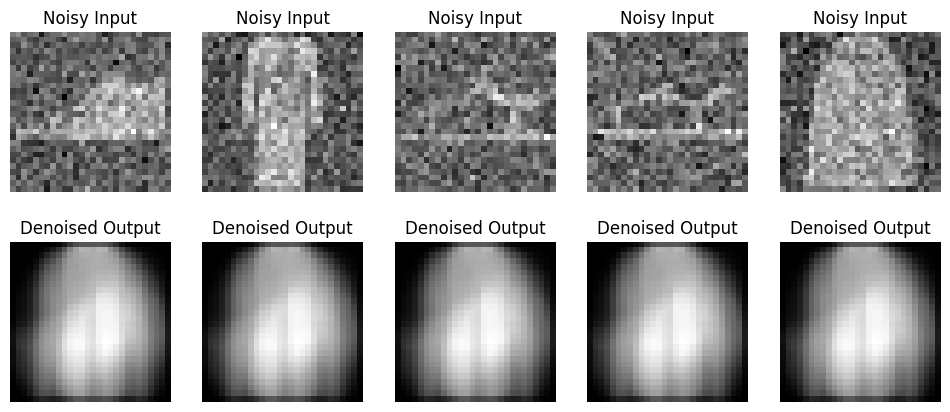

In [48]:
model.eval()
noisy_imgs, _ = next(iter(loader_noisy))
noisy_imgs = noisy_imgs.to(device)

with torch.no_grad():
    denoised = model(noisy_imgs)

# 5 Beispiele anzeigen
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow(noisy_imgs[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title('Noisy Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(denoised[i].cpu().squeeze(), cmap='gray')
    axes[1, i].set_title('Denoised Output')
    axes[1, i].axis('off')

plt.show()


## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import torch

# 1. Latente Repräsentationen holen (Batch für Batch)
latent_vectors = []
true_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Encoder output (z.B. mit model.encoder())
        latents = model.encoder(inputs)
        latent_vectors.append(latents.cpu())
        true_labels.append(labels)

latent_vectors = torch.cat(latent_vectors).numpy()
true_labels = torch.cat(true_labels).numpy()

# 2. KMeans Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

# 3. Qualität messen
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")


Adjusted Rand Index: 0.0303
Normalized Mutual Information: 0.0821
